In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import selene_sdk
import numpy as np


def one_hot_encode(seqs):
    seqs_hot = list()
    for seq in seqs:
        seqs_hot.append(
            selene_sdk.sequences.Genome.sequence_to_encoding(seq).T
        )
    seqs_hot = np.stack(seqs_hot)
    return seqs_hot

class SampleDataset(Dataset):
    
    def __init__(self, data_path):
    
        sequence_key = "sequence"
        activity_key = "expression_log2"
        data_df = pd.read_csv(data_path)

        sequences = data_df[sequence_key]
        self.target = torch.tensor(data_df[activity_key].values, dtype=torch.float)

        self.seqs_hot = one_hot_encode(sequences)
        
    def __len__(self):
        return len(self.target)
    
    def __getitem__(self, idx):
        x = self.seqs_hot[idx]
        y = self.target[idx]

        return x, y

In [2]:
data_dir = "/scratch/bclab/jiayu/Active-learning/Data/new_activity_no_genomic.csv"
df = SampleDataset(data_dir)

In [3]:
from torch.utils.data import DataLoader
pred_dataloader = DataLoader(df, batch_size=256, shuffle=False, num_workers=2)
import torch
import pytorch_lightning as pl
from models.enhancerUncertaintyModel import EnhancerUncertaintyModel

/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
ckpt_dir = "/scratch/bclab/jiayu/Active-learning/ModelFitting/uncertainty/new_genomic/best_genomic.ckpt"

In [5]:
trainer = pl.Trainer(
accelerator='gpu',
    devices=-1,
    max_epochs=1,
    deterministic=True,
    fast_dev_run=False,
)
model = EnhancerUncertaintyModel.load_from_checkpoint(
    ckpt_dir,
    learning_rate=1e-4
)

/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ref/bclab/software/jiayu/.conda/envs/active-learnin ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: U

In [6]:
preds_batch = trainer.predict(model, pred_dataloader)
var_preds = []
for batch in preds_batch:
    for i in range(len(batch[1])):
        var_preds.append(batch[1][i].item())
        
mean_preds = []
for batch in preds_batch:
    for i in range(len(batch[0])):
        mean_preds.append(batch[0][i].item())
var_preds = np.array(var_preds)
mean_preds = np.array(mean_preds)

/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /ref/bclab/software/jiayu/.conda/envs/active-learnin ...
  rank_zero_warn(
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/ref/bclab/software/jiayu/.conda/envs/active-learning/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_

Predicting DataLoader 0: 100%|██████████| 94/94 [00:32<00:00,  2.89it/s]


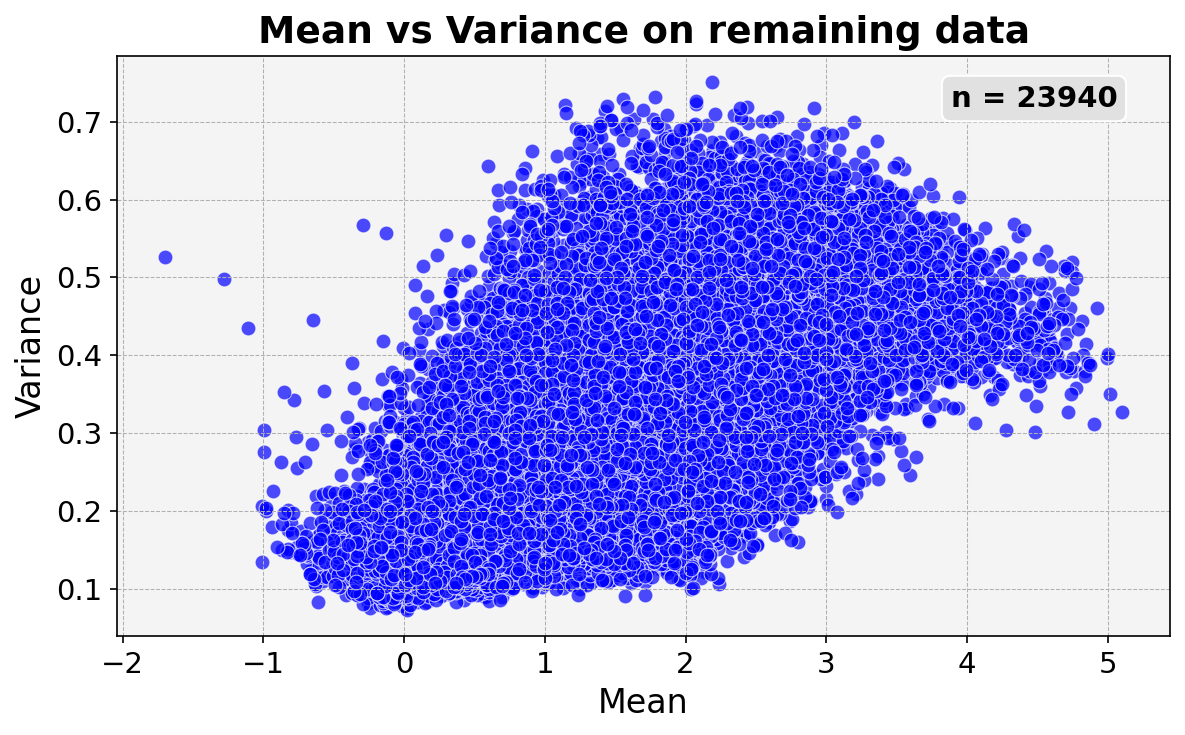

In [7]:
import matplotlib.pyplot as plt
# Create a new figure with a specified size and DPI
plt.figure(figsize=(8, 5), dpi=150)
        
        # Scatter plot with customized marker style, edgecolors and size
plt.scatter(mean_preds, var_preds, alpha=0.7, c='blue', edgecolors='w', s=50, linewidth=0.5)

        # Titles, labels with font size and weight adjustments
plt.title("Mean vs Variance on remaining data", fontsize=18, fontweight='bold')
plt.xlabel("Mean", fontsize=16)
plt.ylabel("Variance", fontsize=16)
        
        # Tweak the tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
        
        # Optional: Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().set_facecolor("#f4f4f4")  # Set a background color

        # Annotate the number of samples
num_samples = len(mean_preds)
plt.annotate(f"n = {num_samples}", 
                    xy=(0.95, 0.95), 
                    xycoords='axes fraction',
                    fontsize=14,
                    fontweight='bold',
                    ha="right",
                    va="top",
                    bbox=dict(boxstyle="round,pad=0.3", edgecolor="#ffffff", facecolor="#e1e1e1"))


        # Make the plot tight layout
plt.tight_layout()
# compare to non active learning 4k 5k 

### Top-k Uncertainty sampling

In [8]:
# Get the indices that would sort the array
sorted_indices = np.argsort(var_preds)

# Take the last 5000 indices, which correspond to the largest 5000 numbers
largest_indices = sorted_indices[-5000:]

activity_df = pd.read_csv(data_dir)
largest_seqs = activity_df.iloc[largest_indices]
largest_seqs.to_csv("/scratch/bclab/jiayu/Active-learning/Data/new_uncertainty_5k_round1.csv", index=False)

round1_remain_uncertainty = activity_df.drop(largest_seqs.index)
round1_remain_uncertainty.to_csv("/scratch/bclab/jiayu/Active-learning/Data/new_round1_uncertainty_remain.csv", index=False)